In [1]:
import sys
from pathlib import Path
srcdir = Path("../..").resolve()
print(f"Adding {srcdir} to sys.path, this is necessary to import from src")
sys.path.insert(0, str(srcdir))

from pathlib import Path
from src.data.datasets import get_arabic
from src.settings import presets
from src.data import datasets
from src.models import model as m, metrics, train_model
from src.settings import SearchSpace, SearchSpaceGRUTransformer, TrainerSettings, presets
from pathlib import Path
from ray.tune import JupyterNotebookReporter

Adding /workspaces/MLopdracht to sys.path, this is necessary to import from src
2023-06-07 06:24:45.566833
asdf
GRUTransformer


/workspaces/MLopdracht/.venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


a


In [2]:
sys.path

['/workspaces/MLopdracht/.venv/lib/python3.9/site-packages/ray/thirdparty_files',
 '/workspaces/MLopdracht',
 '/workspaces/MLopdracht/dev/notebooks',
 '/home/vscode/.pyenv/versions/3.9.16/lib/python39.zip',
 '/home/vscode/.pyenv/versions/3.9.16/lib/python3.9',
 '/home/vscode/.pyenv/versions/3.9.16/lib/python3.9/lib-dynload',
 '',
 '/workspaces/MLopdracht/.venv/lib/python3.9/site-packages']

In [3]:
trainstreamer, teststreamer = get_arabic(presets)

2023-06-06 19:01:36.613 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTrain.txt already exists, skip download
2023-06-06 19:01:36.616 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTest.txt already exists, skip download
2023-06-06 19:01:36.617 | INFO     | src.datasets:get_arabic:33 - Loading data from /workspaces/MLopdracht/data/raw/ArabicTrain.txt and /workspaces/MLopdracht/data/raw/ArabicTest.txt
2023-06-06 19:01:37.635 | INFO     | src.datasets:get_arabic:49 - Returning trainstreamer, teststreamer


In [4]:
x, y = next(iter(trainstreamer.stream()))
x.shape, y.shape

(torch.Size([64, 56, 13]), torch.Size([64]))

In [15]:
labels = trainstreamer.dataset.get_labels()
unique_set = set(labels)
unique_set, len(unique_set)

({'0f',
  '0m',
  '1f',
  '1m',
  '2f',
  '2m',
  '3f',
  '3m',
  '4f',
  '4m',
  '5f',
  '5m',
  '6f',
  '6m',
  '7f',
  '7m',
  '8f',
  '8m',
  '9f',
  '9m'},
 20)

In [4]:
config = SearchSpace(
    input_size=13,
    output_size=20,
    hidden_size=26,
    dropout=0.1,   
    num_layers=3,     
    tune_dir=Path("models/ray2").resolve(),
    data_dir=presets.datadir.resolve()
)
model = m.LSTM(config.dict())

In [3]:
from src.models.model import GRUTransformer
from filelock import FileLock
import torch

with FileLock(presets.datadir / ".lock"):
    trainstreamer, teststreamer = datasets.get_arabic(
        presets
    )

    # we set up the metric
    accuracy = metrics.Accuracy()

    # and create the model with the config
    model = m.GRUTransformer({
        'input_size': 13,
        'output_size': 20,
        'tune_dir': Path("models/ray2").resolve(),
        'data_dir': presets.datadir.resolve(),
        'hidden_size': 96,
        'dropout_1': 0.05164594234137071,
        'num_layers': 5,
        'num_heads': 2,
        'dim_feedforward_multiplier': 2,
        'num_transformer_layers': 3,
        'dropout_2': 0.07867236925135043
    })

    trainersettings = TrainerSettings(
        epochs=100,
        metrics=[accuracy],
        logdir=presets.logdir,
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        tunewriter=["ray", "mlflow", "tensorboard"],
        scheduler_kwargs={"factor": 0.5, "patience": 5},
        earlystop_kwargs=None,
    )

    trainer = train_model.Trainer(
        model=model,
        settings=trainersettings,
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
    )

    trainer.loop()

2023-06-07 06:25:04.736 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTrain.txt already exists, skip download
2023-06-07 06:25:04.738 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTest.txt already exists, skip download
2023-06-07 06:25:04.739 | INFO     | src.datasets:get_arabic:33 - Loading data from /workspaces/MLopdracht/data/raw/ArabicTrain.txt and /workspaces/MLopdracht/data/raw/ArabicTest.txt
2023-06-07 06:25:05.721 | INFO     | src.datasets:get_arabic:49 - Returning trainstreamer, teststreamer
2023-06-07 06:25:05.744 | INFO     | src.data_tools:dir_add_timestamp:137 - Logging to /workspaces/MLopdracht/logs/20230607-0625
  0%|          | 0/100 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [17]:
from torchsummary import summary
summary(model, input_size=(1, 13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 1, 120], [-1, 2, 120]]               0
MultiheadAttention-2  [[-1, 1, 120], [-1, 1, 1]]               0
            Linear-3                   [-1, 20]           2,420
Total params: 2,420
Trainable params: 2,420
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [7]:
from graphviz import Digraph
import torch
from torch import nn
dot = Digraph(comment='Transformer')

In [8]:
for name, module in model.named_modules():
    if isinstance(module, nn.Module):
        dot.node(name, str(module))

In [9]:
for name, module in model.named_modules():
    if isinstance(module, nn.Module):
        for child_name, child_module in module.named_modules():
            if isinstance(child_module, nn.Module):
                dot.edge(name, child_name)

In [10]:
dot.format = 'png'
dot.render('transformer_model_graph', view=False)

# Open the image file
image = Image.open('transformer_model_graph.png')

# Display the image
display.display(image)

NameError: name 'Image' is not defined

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.models import metrics

optimizer = optim.Adam
loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

In [19]:
yhat = model(x)
y, yhat, accuracy(y, yhat)


(tensor([ 6,  5, 17, 11,  5,  2,  2, 11, 16, 18,  2,  2, 16,  4, 10, 12, 15,  9,
          3,  1, 17,  4, 12,  5,  8,  3, 12, 14,  5,  0, 12,  5, 12, 18,  6,  2,
         17, 10, 15,  8, 14,  5, 19,  6,  8,  9, 17,  3, 17,  4, 18,  0,  7, 14,
         12, 13,  6, 18, 17, 14, 16,  5, 13, 10]),
 tensor([[-0.0041, -0.0114, -0.0173,  ..., -0.0864,  0.0755,  0.0120],
         [-0.0050, -0.0141, -0.0168,  ..., -0.0838,  0.0713,  0.0114],
         [-0.0132, -0.0162, -0.0105,  ..., -0.0897,  0.0659,  0.0132],
         ...,
         [-0.0057, -0.0125, -0.0166,  ..., -0.0864,  0.0730,  0.0113],
         [-0.0106, -0.0166, -0.0175,  ..., -0.0801,  0.0731,  0.0111],
         [-0.0107, -0.0123, -0.0107,  ..., -0.0961,  0.0752,  0.0141]],
        grad_fn=<AddmmBackward0>),
 tensor(0.0469))

In [20]:
loss = loss_fn(yhat, y)

In [21]:
loss

tensor(2.9973, grad_fn=<NllLossBackward0>)

In [4]:
tune_dir = Path("../../models/ray2").resolve()
tune_dir.exists()
tune_dir

PosixPath('/workspaces/MLopdracht/models/ray2')

In [5]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)

analysis = ExperimentAnalysis(tune_dir)

2023-06-07 12:46:12,141	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4294959104 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=9.28gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-06-07 12:46:12,340	INFO worker.py:1625 -- Started a local Ray instance.
2023-06-07 12:46:20,822	INFO experiment_analysis.py:812 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [6]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'time_this_iter_s',
       'done', 'timesteps_total', 'episodes_total', 'training_iteration',
       'date', 'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/input_size', 'config/output_size', 'config/tune_dir',
       'config/data_dir', 'config/hidden_size', 'config/dropout_1',
       'config/num_layers', 'config/num_heads', 'config/dropout_2',
       'config/dim_feedforward_multiplier', 'config/num_transformer_layers'],
      dtype='object')

In [21]:
plot = analysis.results_df
# select = ["Accuracy", 'train_loss', 'test_loss', 'iterations']
select = ["Accuracy", 'train_loss', 'test_loss', "config/hidden_size", "config/dropout_1", "config/dropout_2", 'config/num_heads', "config/num_layers", 'config/num_transformer_layers', 'iterations']

p = plot[select].reset_index().dropna()

In [22]:
p.sort_values("Accuracy", inplace=True)

In [15]:
import plotly.express as px
px.parallel_coordinates(p, color="Accuracy")

In [23]:
bla = analysis.get_best_trial(metric="test_loss", mode="min")
bla

lambda_0daddc57

In [24]:
p[-10:]

,trial_id,Accuracy,train_loss,test_loss,config/hidden_size,config/dropout_1,config/dropout_2,config/num_heads,config/num_layers,config/num_transformer_layers,iterations
3,2a012d23,0.956342,0.003452,0.356005,128,0.078610,0.174595,4.0,5,3.0,99
1,0daddc57,0.983456,0.024864,0.086757,96,0.051646,0.078672,2.0,5,3.0,49


In [10]:
best_trial = analysis.get_best_config(metric="Accuracy", mode="max")


In [11]:
best_trial

{'input_size': 13,
 'output_size': 20,
 'tune_dir': PosixPath('/workspaces/MLopdracht/models/ray2'),
 'data_dir': PosixPath('/workspaces/MLopdracht/data/raw'),
 'hidden_size': 96,
 'dropout_1': 0.05164594234137071,
 'num_layers': 5,
 'num_heads': 2,
 'dim_feedforward_multiplier': 2,
 'num_transformer_layers': 3,
 'dropout_2': 0.07867236925135043}

In [112]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import set_config

set_config(display='diagram')

# Define the pipeline steps
preprocessor = StandardScaler()
classifier = SVC()
# accuracy = metrics.Accuracy()
pipeline = make_pipeline(model)

# Visualize the pipeline
pipeline

Pipeline(steps=[('attentiongruaarabic',
                 AttentionGRUAarabic(
  (rnn): GRU(13, 120, num_layers=4, batch_first=True, dropout=0.02319741641270231)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
  )
  (linear): Linear(in_features=120, out_features=20, bias=True)
))])

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import set_config
from sklearn import set_config, compose
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris

set_config(display='diagram')

# Define the pipeline steps
preprocessor = StandardScaler()
classifier = SVC()

# Create the pipeline
# pipeline = make_pipeline(preprocessor, model, classifier)
pipeline = make_pipeline(preprocessor, 'passthrough', classifier)

# Load example data
X, y = load_iris(return_X_y=True)

# Fit the pipeline
pipeline.fit(X, y)

# Save the pipeline diagram as an image
compose.plot_pipeline(pipeline, "pipeline.png")

AttributeError: module 'sklearn.compose' has no attribute 'plot_pipeline'

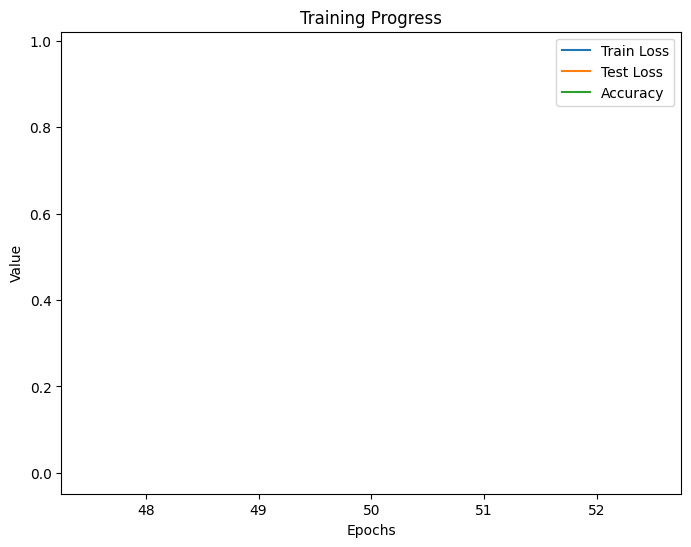

In [110]:
import matplotlib.pyplot as plt

# Extract the metrics from the analysis
best_trial = analysis.get_best_trial("test_loss", mode="min")
# results = best_trial["last_result"]
train_loss = best_trial.last_result["train_loss"]
test_loss = best_trial.last_result["test_loss"]
accuracy = best_trial.last_result["Accuracy"]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# epochs = range(len(train_loss))
plt.plot(50, train_loss, label="Train Loss")
plt.plot(50, test_loss, label="Test Loss")
plt.plot(50, accuracy, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.show()